<h2> Importando bibliotecas

In [96]:
#https://medium.com/analytics-vidhya/how-to-summarize-data-with-pandas-2c9edffafbaf
#https://www.programcreek.com/python/example/96216/seaborn.set_context
#https://towardsdev.com/outlier-detection-using-iqr-method-and-box-plot-in-python-82e1e15232bd

import requests as rq
import pandas as pd

pd.set_option('display.max_columns', None)  # or 1000
#pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('float_format', '{:,.2f}'.format)
#pd.options.display.float_format = 

from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

<h2> Importando o dataframe do arquivo principal

In [97]:
df_header = pd.read_pickle('Header.pkl')

<h2> Importando o arquivo dos itens em dataframe

In [98]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Itens/Api_Itens.xlsx?raw=true"
data = rq.get(url).content
df_itens = pd.read_excel(BytesIO(data))

In [99]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Cadastro%20Fam%C3%ADlias%20Petronect/Geral.xlsx?raw=true"
data = rq.get(url).content
df_familias = pd.read_excel(BytesIO(data))
df_familias.drop(['Tipo da Família','Família'],axis=1,inplace=True)

In [100]:
display(f'itens {df_itens.shape}')
df_itens.info()
df_itens.drop(['Unnamed: 0','EXLIN','YPCOMT_LINE','ATTACHMENTS','SRC_GUID','ITEM_PROCESS_TYP'], axis=1,inplace=True)

'itens (37381, 18)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37381 entries, 0 to 37380
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        37381 non-null  int64  
 1   SRC_GUID          37381 non-null  object 
 2   NUMBER_INT        37381 non-null  object 
 3   DESCRIPTION_UC    37364 non-null  object 
 4   ORDERED_PROD      28601 non-null  object 
 5   YPFAMITEM         32303 non-null  float64
 6   QUANTITY          37381 non-null  float64
 7   UNIT              36387 non-null  object 
 8   UNIT_TEXT         35098 non-null  object 
 9   DELIV_DATE        37381 non-null  object 
 10  EXLIN             37381 non-null  object 
 11  GROUPING_LEVEL    5083 non-null   object 
 12  ITEM_PROCESS_TYP  37361 non-null  object 
 13  YPCOMT_LINE       37381 non-null  object 
 14  ATTACHMENTS       37381 non-null  object 
 15  LOTE              988 non-null    object 
 16  TOTAL             4095 non-null   object

In [101]:
df = df_header.merge(df_itens, on='OPPORT_NUM', how='inner')
df = df.merge(df_familias, on='YPFAMITEM', how='inner')

In [102]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Hist%C3%B3rico/Historico_QUOTS.xlsx?raw=true"
data = rq.get(url).content
df_quots = pd.read_excel(BytesIO(data))
df_quots.drop(['Unnamed: 0','DESCRIPTION'],axis=1,inplace=True)

<h2> Removendo fornecedores que declinaram a participação na licitação

In [103]:
df_quots = df_quots.query('TOTAL_VALUE != "Decline"')

In [104]:
df = df.merge(df_quots, on=['OPPORT_NUM','NUMBER_INT'],how='inner')

<h2> Checando valores faltantes

Text(0.5, 1.0, 'Valores Faltantes')

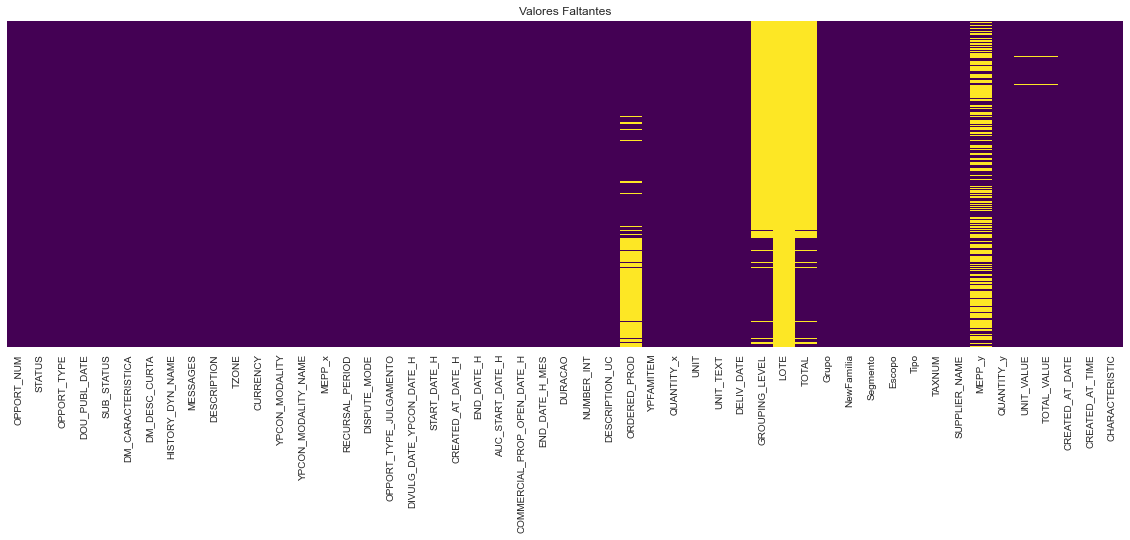

In [105]:
plt.figure(figsize=(20,6))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Valores Faltantes')

In [106]:
for x,t in enumerate(df.columns.to_list()):
    if t.__contains__('x') or t.__contains__('y') :
        print(t)
set(df['QUANTITY_x'] == df['QUANTITY_y'])
df_diff_qtd = df[df['QUANTITY_x'] != df['QUANTITY_y']]

MEPP_x
QUANTITY_x
MEPP_y
QUANTITY_y


In [107]:
df_colunas_obj = df.loc[:, df.dtypes == object]
cols_object = df_colunas_obj.describe().T
cols_object = cols_object.reset_index()
cols_object['dist_uniques'] = (cols_object['unique'] / cols_object['count'])*100
cols_object = cols_object[cols_object['dist_uniques']>10]
lista_objects = cols_object['index'].to_list()
print(lista_objects)

['ORDERED_PROD', 'LOTE', 'UNIT_VALUE', 'TOTAL_VALUE', 'CREATED_AT_TIME']


In [108]:
df_familias = df[['Grupo','NewFamília','OPPORT_NUM','Segmento','Escopo','Tipo']]
#df_familias = df[['Grupo','NewFamília','OPPORT_NUM','Segmento','Escopo','Tipo','DURACAO']]
df_familias = df_familias.drop_duplicates()
#df_familias = df_familias[df_familias['Tipo']=='Bens'] 

In [109]:
df_familias_stats = df_familias.describe(include='O').T.sort_values('unique')
df_familias_stats['rel'] = (df_familias_stats['freq'] / df_familias_stats['count'])*100
df_familias_stats

,count,unique,top,freq,rel
Tipo,6393,2,Bens,3890,60.85
Segmento,6393,4,Operacional,2566,40.14
Grupo,6393,34,M-40 - Sistemas de distribuição e condicioname...,1238,19.36
NewFamília,6393,1129,- Feixe tubular,96,1.50
Escopo,6393,1129,Componentes especialmente fabricados para os p...,96,1.50


In [110]:
df_fam_mat_type = df_familias[['Tipo']].value_counts(normalize=True).rename('%').mul(100).reset_index().sort_values('%', ascending=False)
df_fam_segmento = df_familias[['Tipo','Segmento']].value_counts(normalize=True).rename('%').mul(100).reset_index().sort_values('%', ascending=False)
df_fam_grupo = df_familias[['Tipo','Grupo']].value_counts(normalize=True).rename('%').mul(100).reset_index().sort_values('%', ascending=False)
df_fam_desc = df_familias[['Tipo','NewFamília']].value_counts(normalize=True).rename('%').mul(100).reset_index().sort_values('%', ascending=False)[:20]

Text(0.5, 0, 'Item Process Type')

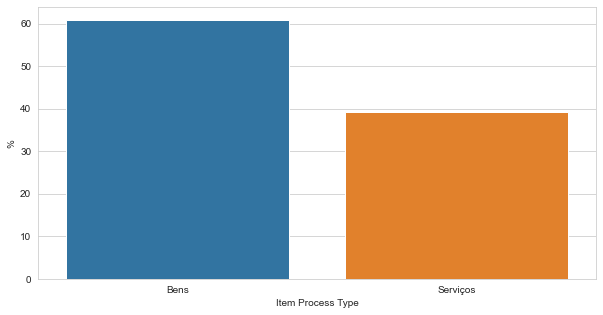

In [111]:
f, ax = plt.subplots(figsize=(10,5))
f.subplots_adjust(hspace=0.5, wspace=.2)
sns.barplot(data=df_fam_mat_type, x='Tipo', y='%')
ax.set_xlabel('Item Process Type')

Text(0.5, 0, 'Item Process Type')

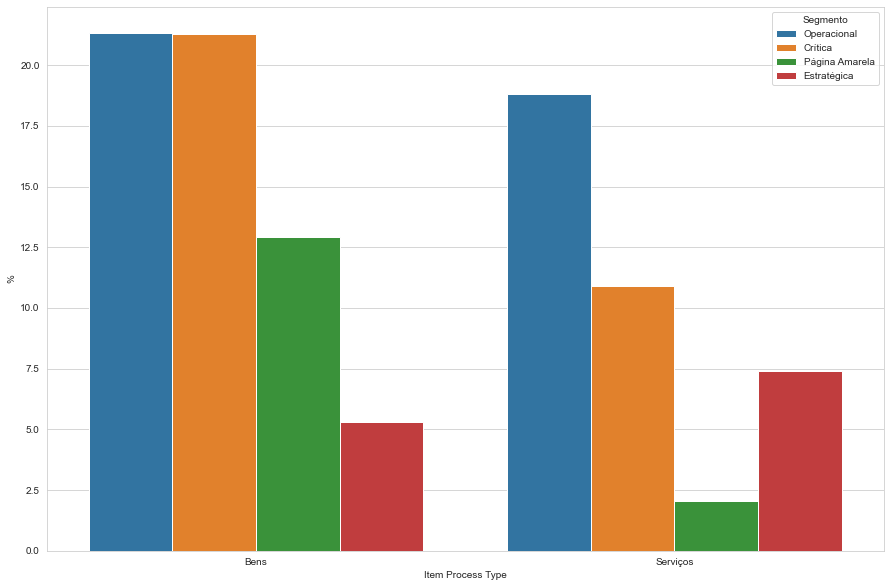

In [112]:
f, ax = plt.subplots(figsize=(15,10))
f.subplots_adjust(hspace=0.5, wspace=.2)
sns.barplot(data=df_fam_segmento, x='Tipo', y='%', hue='Segmento')
ax.set_xlabel('Item Process Type')

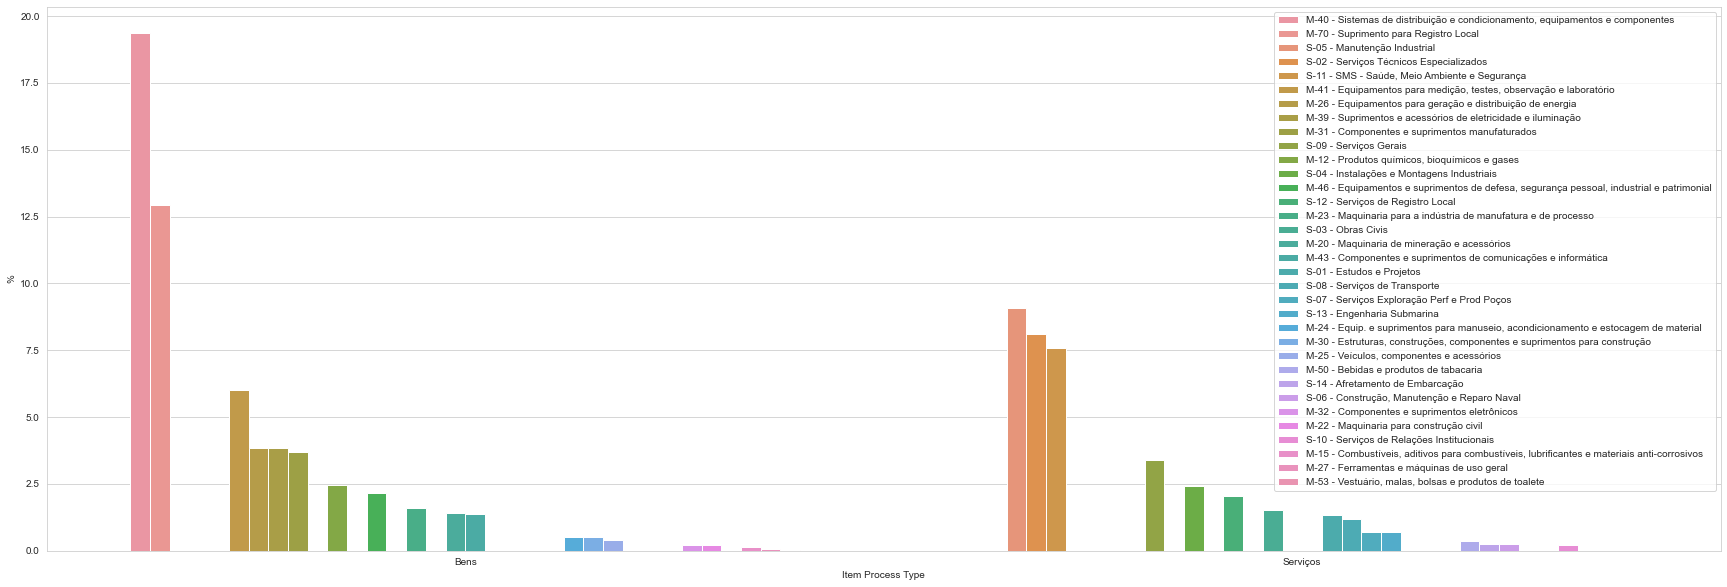

In [113]:
f, ax = plt.subplots(figsize=(30,10))
f.subplots_adjust(hspace=0.5, wspace=.2)
sns.barplot(data=df_fam_grupo, x='Tipo', y='%', hue='Grupo')
ax.set_xlabel('Item Process Type')
ax.legend(loc='upper right')

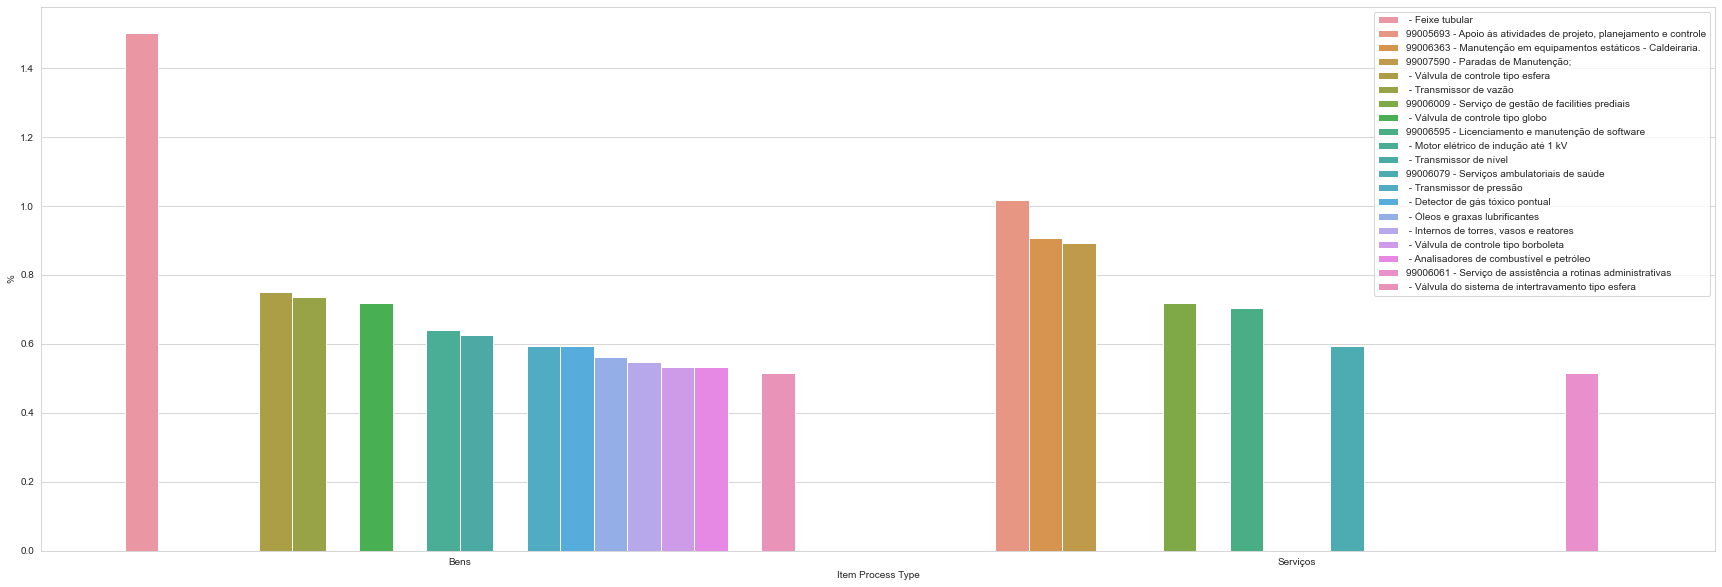

In [114]:
f, ax = plt.subplots(figsize=(30,10))
f.subplots_adjust(hspace=0.5, wspace=.2)
sns.barplot(data=df_fam_desc, x='Tipo', y='%', hue='NewFamília')
ax.set_xlabel('Item Process Type')
ax.legend(loc="upper right")

In [115]:
df['UNIT_VALUE_tmp'] = df['UNIT_VALUE'].str.replace('.','').str.strip()
df['UNIT_VALUE'] = df['UNIT_VALUE_tmp'].str.replace(',','.').astype('float')
df.drop('UNIT_VALUE_tmp', axis=1,inplace=True)

C:\Users\kairo\AppData\Local\Temp\ipykernel_5168\1534235725.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['UNIT_VALUE_tmp'] = df['UNIT_VALUE'].str.replace('.','').str.strip()


In [116]:
df['TOTAL_VALUE_tmp'] = df['TOTAL_VALUE'].str.replace('.','').str.strip()
df['TOTAL_VALUE'] = df['TOTAL_VALUE_tmp'].str.replace(',','.').astype('float')
df.drop('TOTAL_VALUE_tmp', axis=1,inplace=True)

C:\Users\kairo\AppData\Local\Temp\ipykernel_5168\1323756818.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['TOTAL_VALUE_tmp'] = df['TOTAL_VALUE'].str.replace('.','').str.strip()


In [117]:
df['Chave'] = df['OPPORT_NUM'].astype('str') + '--'  + df['NUMBER_INT']

In [118]:
df[df['Chave']=='7003385047--0001']

,OPPORT_NUM,STATUS,OPPORT_TYPE,DOU_PUBL_DATE,SUB_STATUS,DM_CARACTERISTICA,DM_DESC_CURTA,HISTORY_DYN_NAME,MESSAGES,DESCRIPTION,TZONE,CURRENCY,YPCON_MODALITY,YPCON_MODALITY_NAME,MEPP_x,RECURSAL_PERIOD,DISPUTE_MODE,OPPORT_TYPE_JULGAMENTO,DIVULG_DATE_YPCON_DATE_H,START_DATE_H,CREATED_AT_DATE_H,END_DATE_H,AUC_START_DATE_H,COMMERCIAL_PROP_OPEN_DATE_H,END_DATE_H_MES,DURACAO,NUMBER_INT,DESCRIPTION_UC,ORDERED_PROD,YPFAMITEM,QUANTITY_x,UNIT,UNIT_TEXT,DELIV_DATE,GROUPING_LEVEL,LOTE,TOTAL,Grupo,NewFamília,Segmento,Escopo,Tipo,TAXNUM,SUPPLIER_NAME,MEPP_y,QUANTITY_y,UNIT_VALUE,TOTAL_VALUE,CREATED_AT_DATE,CREATED_AT_TIME,CHARACTERISTIC,Chave
69489,7003385047,SEM STATUS - SEM STATUS_DESC,LIDL - LICITAÇÃO PÚBLICA DFP INTEGRADA LOTE,2020-12-31,3 - Adjudicado,VENCEDOR PELA MELHOR PROPOSTA,ENVELOPE,Historic,X,AQUISICÃO DE TUBOS DE PRODUCÃO E REVESTIMENTO ...,Brazil - Distrito Federal,BRL,101.00,"Licitação, Lei 13.303, Art. 28, CAPUT",SEM MEPP,2021-07-08,2 - MODO DE DISPUTA FECHADO,LOTE,2021-10-01 10:29:17,2020-12-31 12:00:00,2020-12-22 15:27:05,2021-03-22 15:00:00,1900-01-01,2021-03-22 15:00:00,2021-03,81,0001,OCTG LOTE 1,NaN,"98,010,204.00",1.00,EA,Each,2020-12-25,NaN,NaN,NaN,M-40 - Sistemas de distribuição e condicioname...,- Tubo para coluna de produção,Estratégica,Componentes tubulares da coluna de produção fa...,Bens,019901008692,SUMITOMO CORPORATION OF AMERICAS,NaN,1.00,1.00,0.89,2021-03-18,10:47:32,Featured Quotation,7003385047--0001
69490,7003385047,SEM STATUS - SEM STATUS_DESC,LIDL - LICITAÇÃO PÚBLICA DFP INTEGRADA LOTE,2020-12-31,3 - Adjudicado,VENCEDOR PELA MELHOR PROPOSTA,ENVELOPE,Historic,X,AQUISICÃO DE TUBOS DE PRODUCÃO E REVESTIMENTO ...,Brazil - Distrito Federal,BRL,101.00,"Licitação, Lei 13.303, Art. 28, CAPUT",SEM MEPP,2021-07-08,2 - MODO DE DISPUTA FECHADO,LOTE,2021-10-01 10:29:17,2020-12-31 12:00:00,2020-12-22 15:27:05,2021-03-22 15:00:00,1900-01-01,2021-03-22 15:00:00,2021-03,81,0001,OCTG LOTE 1,NaN,"98,010,204.00",1.00,EA,Each,2020-12-25,NaN,NaN,NaN,M-40 - Sistemas de distribuição e condicioname...,- Tubo para coluna de produção,Estratégica,Componentes tubulares da coluna de produção fa...,Bens,08689024000101,VALLOUREC SOLUCOES TUBULARES DO BRASIL S.A.,NaN,1.00,5.09,4.53,2021-03-05,11:56:32,Featured Quotation,7003385047--0001
69491,7003385047,SEM STATUS - SEM STATUS_DESC,LIDL - LICITAÇÃO PÚBLICA DFP INTEGRADA LOTE,2020-12-31,3 - Adjudicado,VENCEDOR PELA MELHOR PROPOSTA,ENVELOPE,Historic,X,AQUISICÃO DE TUBOS DE PRODUCÃO E REVESTIMENTO ...,Brazil - Distrito Federal,BRL,101.00,"Licitação, Lei 13.303, Art. 28, CAPUT",SEM MEPP,2021-07-08,2 - MODO DE DISPUTA FECHADO,LOTE,2021-10-01 10:29:17,2020-12-31 12:00:00,2020-12-22 15:27:05,2021-03-22 15:00:00,1900-01-01,2021-03-22 15:00:00,2021-03,81,0001,OCTG LOTE 1,NaN,"98,010,204.00",1.00,EA,Each,2020-12-25,NaN,NaN,NaN,M-40 - Sistemas de distribuição e condicioname...,- Tubo para coluna de produção,Estratégica,Componentes tubulares da coluna de produção fa...,Bens,60882628004268,CONFAB INDUSTRIAL SOCIEDADE ANONIMA,NaN,1.00,5.10,9.65,2021-02-25,14:09:29,Featured Quotation,7003385047--0001
69492,7003385047,SEM STATUS - SEM STATUS_DESC,LIDL - LICITAÇÃO PÚBLICA DFP INTEGRADA LOTE,2020-12-31,3 - Adjudicado,VENCEDOR PELA MELHOR PROPOSTA,ENVELOPE,Historic,X,AQUISICÃO DE TUBOS DE PRODUCÃO E REVESTIMENTO ...,Brazil - Distrito Federal,BRL,101.00,"Licitação, Lei 13.303, Art. 28, CAPUT",SEM MEPP,2021-07-08,2 - MODO DE DISPUTA FECHADO,LOTE,2021-10-01 10:29:17,2020-12-31 12:00:00,2020-12-22 15:27:05,2021-03-22 15:00:00,1900-01-01,2021-03-22 15:00:00,2021-03,81,0001,OCTG LOTE 1,NaN,"98,010,204.00",1.00,EA,Each,2020-12-25,NaN,NaN,NaN,M-40 - Sistemas de distribuição e condicioname...,- Tubo para coluna de produção,Estratégica,Componentes tubulares da coluna de produção fa...,Bens,A-95831251,TUBACEX UPSTREAM TECHNOLOGIES S.A.,NaN,1.00,"217,577,907.22","192,626,312.34",2021-03-15,18:06:37,Awarded,7003385047--0001


In [119]:
def calc_upper_limit(series):
    # IQR
    # Find Q1, Q3
    # 1.
    Q1 = np.percentile(series , 25)
    Q3 = np.percentile(series, 75)
    # 2.
    Q1,Q3 = np.percentile(series, [25,75])
    # Find IQR, upper limit, lower limit
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR

    # Find outliers
    
    return ul

def calc_lower_limit(series):
    # IQR
    # Find Q1, Q3
    # 1.
    Q1 = np.percentile(series , 25)
    Q3 = np.percentile(series, 75)
    # 2.
    Q1,Q3 = np.percentile(series, [25,75])
    # Find IQR, upper limit, lower limit
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR
    # Find outliers
    return ll

In [120]:
df_iqr_ul_ll = df.groupby(['Chave'])['TOTAL_VALUE'].agg([calc_upper_limit,calc_lower_limit]).reset_index()
df_iqr_ul_ll

,Chave,calc_upper_limit,calc_lower_limit
0,7001981014--0001,"2,018,999.50","-672,998.50"
1,7001981474--8001,"1,045,144.00","1,045,144.00"
2,7001982249--0001,"349,498.60","-76,479.86"
3,7001982249--0002,"298,538.46","110,533.50"
4,7001982249--0003,"278,218.80","-77,449.20"
...,...,...,...
15657,7003876698--0001,"501,316.47","282,788.36"
15658,7003876698--0002,"305,519.06","24,676.60"
15659,7003889769--0001,"165,287.77","125,352.74"
15660,7003889769--0002,"57,712.35","16,516.61"


In [121]:
df_outliers = df.merge(df_iqr_ul_ll, on='Chave')

In [122]:
df_outliers['OUTLIER_IQR_UL'] = ((df_outliers['TOTAL_VALUE'] > df_outliers['calc_upper_limit']))             
df_outliers['OUTLIER_IQR_LL'] = ((df_outliers['TOTAL_VALUE'] < df_outliers['calc_lower_limit']))

In [123]:
#df_outliers = df_outliers.drop(df_outliers.query("OUTLIER_IQR_UL or OUTLIER_IQR_LL").index)

In [124]:
#df_outliers.drop(['OUTLIER_IQR_LL','OUTLIER_IQR_UL','calc_lower_limit','calc_upper_limit','Chave'], axis=1, inplace=True)

In [125]:
df_outliers.to_pickle('Itens.pkl')
df_outliers.to_excel('Itens.xlsx')

In [126]:
df_outliers.head()

,OPPORT_NUM,STATUS,OPPORT_TYPE,DOU_PUBL_DATE,SUB_STATUS,DM_CARACTERISTICA,DM_DESC_CURTA,HISTORY_DYN_NAME,MESSAGES,DESCRIPTION,TZONE,CURRENCY,YPCON_MODALITY,YPCON_MODALITY_NAME,MEPP_x,RECURSAL_PERIOD,DISPUTE_MODE,OPPORT_TYPE_JULGAMENTO,DIVULG_DATE_YPCON_DATE_H,START_DATE_H,CREATED_AT_DATE_H,END_DATE_H,AUC_START_DATE_H,COMMERCIAL_PROP_OPEN_DATE_H,END_DATE_H_MES,DURACAO,NUMBER_INT,DESCRIPTION_UC,ORDERED_PROD,YPFAMITEM,QUANTITY_x,UNIT,UNIT_TEXT,DELIV_DATE,GROUPING_LEVEL,LOTE,TOTAL,Grupo,NewFamília,Segmento,Escopo,Tipo,TAXNUM,SUPPLIER_NAME,MEPP_y,QUANTITY_y,UNIT_VALUE,TOTAL_VALUE,CREATED_AT_DATE,CREATED_AT_TIME,CHARACTERISTIC,Chave,calc_upper_limit,calc_lower_limit,OUTLIER_IQR_UL,OUTLIER_IQR_LL
0,7001983403,E0005 - PATEC cancelled,LICI - LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-02-09,1 - Todos,VENCEDOR PELA MELHOR PROPOSTA,ENVELOPE,Historic,X,CALHA PARA CABOS ELÉTRICOS,Brazil - Distrito Federal,BRL,101.00,"Licitação, Lei 13.303, Art. 28, CAPUT",X,2018-05-24,2 - MODO DE DISPUTA FECHADO,ITEM,2018-05-25 09:07:05,2018-02-09 11:00:00,2018-02-07 14:28:38,2018-02-23 12:00:00,1900-01-01,2018-02-23 12:00:00,2018-02,14,0001,CALHA ELÉTRICA PERFUR. 50X 50X 3M,10315576,"98,010,534.00",200.00,EA,Each,2018-01-30,NaN,NaN,NaN,M-70 - Suprimento para Registro Local,- Calhas para cabos elétricos,Página Amarela,"Conduto utilizado em instalações aparentes, ab...",Bens,29636755000169,WILLIAM CATRINCK 08477596794,X,200.00,60.00,"12,000.00",2018-02-19,10:35:14,Renunciation,7001983403--0001,"73,307.73",415.36,False,False
1,7001983403,E0005 - PATEC cancelled,LICI - LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-02-09,1 - Todos,VENCEDOR PELA MELHOR PROPOSTA,ENVELOPE,Historic,X,CALHA PARA CABOS ELÉTRICOS,Brazil - Distrito Federal,BRL,101.00,"Licitação, Lei 13.303, Art. 28, CAPUT",X,2018-05-24,2 - MODO DE DISPUTA FECHADO,ITEM,2018-05-25 09:07:05,2018-02-09 11:00:00,2018-02-07 14:28:38,2018-02-23 12:00:00,1900-01-01,2018-02-23 12:00:00,2018-02,14,0001,CALHA ELÉTRICA PERFUR. 50X 50X 3M,10315576,"98,010,534.00",200.00,EA,Each,2018-01-30,NaN,NaN,NaN,M-70 - Suprimento para Registro Local,- Calhas para cabos elétricos,Página Amarela,"Conduto utilizado em instalações aparentes, ab...",Bens,17966444000189,IMOTEC INDUSTRIA MECANICA DE OBRAS TECNICAS E...,X,200.00,165.00,"33,000.00",2018-02-20,10:04:33,Homologated,7001983403--0001,"73,307.73",415.36,False,False
2,7001983403,E0005 - PATEC cancelled,LICI - LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-02-09,1 - Todos,VENCEDOR PELA MELHOR PROPOSTA,ENVELOPE,Historic,X,CALHA PARA CABOS ELÉTRICOS,Brazil - Distrito Federal,BRL,101.00,"Licitação, Lei 13.303, Art. 28, CAPUT",X,2018-05-24,2 - MODO DE DISPUTA FECHADO,ITEM,2018-05-25 09:07:05,2018-02-09 11:00:00,2018-02-07 14:28:38,2018-02-23 12:00:00,1900-01-01,2018-02-23 12:00:00,2018-02,14,0001,CALHA ELÉTRICA PERFUR. 50X 50X 3M,10315576,"98,010,534.00",200.00,EA,Each,2018-01-30,NaN,NaN,NaN,M-70 - Suprimento para Registro Local,- Calhas para cabos elétricos,Página Amarela,"Conduto utilizado em instalações aparentes, ab...",Bens,23288955000191,DORAL BRASIL INTERNATIONAL SUPPLY LTDA. - ME,X,200.00,188.00,"37,600.00",2018-02-22,14:42:12,Disqualification Technical Opinion,7001983403--0001,"73,307.73",415.36,False,False
3,7001983403,E0005 - PATEC cancelled,LICI - LICITAÇÃO PÚBLICA INTEGRADA ITEM,2018-02-09,1 - Todos,VENCEDOR PELA MELHOR PROPOSTA,ENVELOPE,Historic,X,CALHA PARA CABOS ELÉTRICOS,Brazil - Distrito Federal,BRL,101.00,"Licitação, Lei 13.303, Art. 28, CAPUT",X,2018-05-24,2 - MODO DE DISPUTA FECHADO,ITEM,2018-05-25 09:07:05,2018-02-09 11:00:00,2018-02-07 14:28:38,2018-02-23 12:00:00,1900-01-01,2018-02-23 12:00:00,2018-02,14,0001,CALHA ELÉTRICA PERFUR. 50X 50X 3M,10315576,"98,010,534.00",200.00,EA,Each,2018-01-30,NaN,NaN,NaN,M-70 - Suprimento para Registro Local,- Calhas para cabos elétricos,Página Amarela,"Conduto utilizado em instalações aparentes, ab...",Bens,07530275000186,APOIO ENGENHARIA E MONTAGENS LTDA - EPP,X,200.00,103.28,"71,092.37",2018-02-21,07:55:28,Disability - Technical qualificatio

In [299]:
from numpy import int64
df_cnpjs = pd.DataFrame(list(set(df_outliers.TAXNUM.to_list())), columns=['cnpj'])


In [300]:
df_cnpjs['cnpj'] = df_cnpjs['cnpj'].apply(lambda x: str(x).replace('.','').replace('-',''))

In [301]:
df_cnpjs['cnpj'] = df_cnpjs['cnpj'].str.extract('(\d+)', expand=False)

In [302]:
df_cnpjs = df_cnpjs.dropna(axis='rows',how='any')

In [303]:
df_cnpjs.drop_duplicates(inplace=True)

In [304]:
df_cnpjs['cnpj'] = df_cnpjs['cnpj'].apply(lambda x: x[:14])

In [305]:
df_cnpjs['len'] = df_cnpjs['cnpj'].apply(lambda x: len(x))

In [306]:
df_cnpjs = df_cnpjs[df_cnpjs['len']>12]

In [308]:
df_cnpjs['cnpj_basico'] = df_cnpjs['cnpj'].apply(lambda x: str(x)[:-6]).astype(int64)
df_cnpjs['cnpj_dv'] = df_cnpjs['cnpj'].apply(lambda x: str(x)[-2:]).astype(int64)
df_cnpjs['cnpj_ordem'] = df_cnpjs['cnpj'].apply(lambda x: str(x)[-6:-2]).astype(int64)

In [309]:
df_cnpjs.to_pickle('C:\Cnpjs\99 - cnpj\cnpjs.pkl')
df_cnpjs.to_excel('C:\Cnpjs\99 - cnpj\cnpjs.xlsx')